# Space example
This is taken largely from ?Space with some info from Nicole's tutorial.
There is useful info here: https://figshare.com/articles/dataset/pub_shobe_etal_GMD/5193478
although lots of the code there is depreciated so it does not run as written.

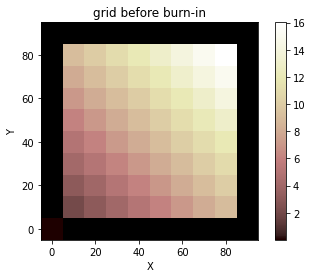

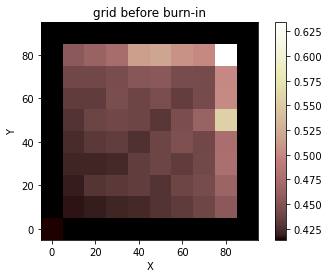

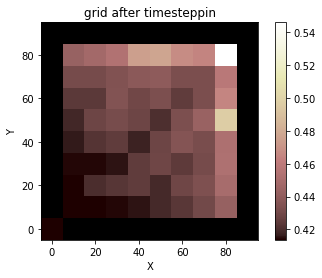

In [78]:
# this is from the space help
import numpy as np
import matplotlib.pyplot as plt 
from landlab.components import (DepressionFinderAndRouter,
                                FastscapeEroder,
                                FlowAccumulator,
                                Space)
from landlab import (RasterModelGrid,
                     imshow_grid)
%matplotlib inline


# 5x5 grid with baselevel in lower left corner
# all other boundary nodes closed
# init topography is plane tilted up to the upper right with noise

mg = RasterModelGrid((10, 10), xy_spacing=10.0)
_ = mg.add_zeros('topographic__elevation', at='node')
mg.at_node['topographic__elevation'] += (mg.node_y / 10. + 
                                         mg.node_x / 10. + np.random.rand(len(mg.node_y)) / 10.)
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,
                                        left_is_closed=True,
                                        right_is_closed=True,
                                        top_is_closed=True)
mg.set_watershed_boundary_condition_outlet_id(
     0, mg.at_node['topographic__elevation'], -9999.)
fsc_dt = 100.
space_dt = 100.

# show the pre-burn-in grid
mg.imshow('node','topographic__elevation')
plt.title('grid before burn-in')
plt.show()



#Instantiate Fastscape eroder, flow router, and depression finder
fr = FlowAccumulator(mg, flow_director='D8')
df = DepressionFinderAndRouter(mg)
fsc = FastscapeEroder(
    mg,
    K_sp=.001,
    m_sp=.5,
    n_sp=1)

# burn in an initial drainage ntework using the fastscape eroder
for x in range(100):
    fr.run_one_step()
    df.map_depressions()
    fsc.run_one_step(dt=fsc_dt)
    mg.at_node['topographic__elevation'][0] -= 0.001 # Uplift
    
# add soil to the drainage network
_ = mg.add_zeros('soil__depth', at='node', dtype=float) 
mg.at_node['soil__depth'] += 0.5
mg.at_node['topographic__elevation'] += mg.at_node['soil__depth']


# plot after burn-in grid
mg.imshow('node','topographic__elevation')
plt.title('grid after burn-in')
plt.show()




# init the space component
ha = Space(
    mg,
    K_sed=0.00001,
    K_br=0.00000000001,
    F_f=0.5,
    phi=0.1,
    H_star=1.,
    v_s=0.001,
    m_sp=0.5,
    n_sp = 1.0,
    sp_crit_sed=0,
    sp_crit_br=0)

# run Space component for 2000 short timesteps:

for x in range(2000): #Space component loop
    fr.run_one_step()
    df.map_depressions()
    ha.run_one_step(dt=space_dt)
    mg.at_node['bedrock__elevation'][0] -= 2e-6 * space_dt
    
# plot after iteration grid
mg.imshow('node','topographic__elevation')
plt.title('grid after timesteppin')
plt.show()

# Laurent's example

In [17]:
import inspect
inspect.getmodule(ha)

<module 'landlab.components.space.space' from '/home/kp/anaconda3/envs/espin/lib/python3.9/site-packages/landlab/components/space/space.py'>

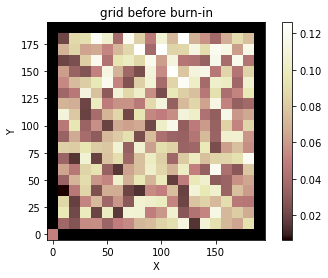

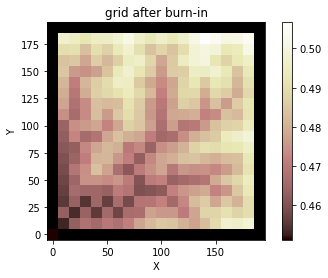

-- 0.0 years -- 0.0 seconds --
-- 10000.0 years -- 3.5 seconds --
-- 20000.0 years -- 7.3 seconds --
-- 30000.0 years -- 10.9 seconds --
-- 40000.0 years -- 14.6 seconds --
-- 50000.0 years -- 18.1 seconds --
-- 60000.0 years -- 21.7 seconds --
-- 70000.0 years -- 25.1 seconds --
-- 80000.0 years -- 28.5 seconds --
-- 90000.0 years -- 31.9 seconds --
-- 100000.0 years -- 35.4 seconds --
-- 110000.0 years -- 38.8 seconds --
-- 120000.0 years -- 42.3 seconds --
-- 130000.0 years -- 45.8 seconds --
-- 140000.0 years -- 49.1 seconds --
-- 150000.0 years -- 52.5 seconds --
-- 160000.0 years -- 56.1 seconds --
-- 170000.0 years -- 59.5 seconds --
-- 180000.0 years -- 63.0 seconds --
-- 190000.0 years -- 66.5 seconds --


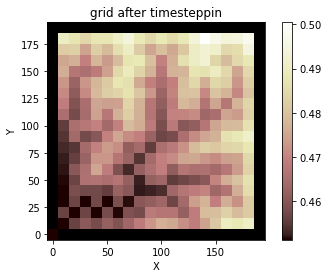

In [26]:
import numpy as np
from landlab import RasterModelGrid, imshow_grid
from landlab.components import (FlowAccumulator,
                                DepressionFinderAndRouter,
                                Space,
                                FastscapeEroder)
import matplotlib.pyplot as plt
%matplotlib inline
import time

# Set up raster model grid
#np.random.seed(seed = 5000)

mg = RasterModelGrid((20, 20), xy_spacing=10.0)
_ = mg.add_zeros('topographic__elevation', at='node')
mg.at_node['topographic__elevation'] += (mg.node_y / 10000. +
                                         mg.node_x / 10000. +
                                         np.random.rand(len(mg.node_y)) / 10.)
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,
                                       left_is_closed=True,
                                       right_is_closed=True,
                                       top_is_closed=True)
mg.set_watershed_boundary_condition_outlet_id(
    0, mg.at_node['topographic__elevation'], -9999.)
fsc_dt = 100.
space_dt = 100.


# show the pre-burn-in grid
mg.imshow('node','topographic__elevation')
plt.title('grid before burn-in')
plt.show()

# Instantiate Fastscape eroder, flow router, and depression finder

fr = FlowAccumulator(mg, flow_director='D8')
df = DepressionFinderAndRouter(mg)
fsc = FastscapeEroder(mg, K_sp=.001, m_sp=.5, n_sp=1)

# Burn in an initial drainage network using the Fastscape eroder:

for x in range(100):
    fr.run_one_step()
    df.map_depressions()
    fsc.run_one_step(dt=fsc_dt)
    mg.at_node['topographic__elevation'][0] -= 0.001 # Uplift

# add soil to the drainage network
_ = mg.add_zeros('soil__depth', at='node', dtype=float) 
mg.at_node['soil__depth'] += 0.5
mg.at_node['topographic__elevation'] += mg.at_node['soil__depth']

# plot after burn-in grid
mg.imshow('node','topographic__elevation')
plt.title('grid after burn-in')
plt.show()

#%% Instantiate the Space component:
ha = Space(mg,
           K_sed=0.00001,
           K_br=0.00000000001,
           F_f=0.5,
           phi=0.1,
           H_star=1.,
           v_s=0.001, # 5
           m_sp=0.5,
           n_sp = 1.0,
           sp_crit_sed=0,
           sp_crit_br=0,
           solver='basic')


## NEW ELEMENT. THIS SETS AN ARRAY FOR THE ERODIBILITY
# try an initial array for the soil erodibility... 
ha.Ksed = np.ones(mg.shape)*0.00001 # that works fine.

start_time = time.time()
for x in range(2000):
    fr.run_one_step()
    df.map_depressions()
    ha.run_one_step(dt=space_dt)
    mg.at_node['bedrock__elevation'][0] -= 2e-6 * space_dt
    ############################ Update Erodibility
    ha.Ksed = ha.Ksed*(1+5/2000) # THIS IS CHANGING ERODIBILITY ON EACH TIMESTEP.
    ############################
    if x % 100 == 0:
        print("--", x*space_dt, "years -- %s seconds --" % round((time.time() - start_time), 1))
        #print(mg.at_node['topographic__elevation'][50:60])
    
# plot after iteration grid
mg.imshow('node','topographic__elevation')
plt.title('grid after timesteppin')
plt.show()

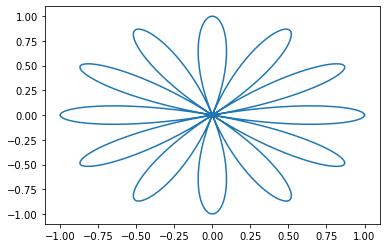

In [52]:
import matplotlib.pyplot as plt
import math
  
#lt.axes(projection='polar')
  
a = 1
k = 6
t = np.linspace(0, (2* np.pi),1000) 
x = a*np.cos(k*t)*np.cos(t)
y = a*np.cos(k*t)*np.sin(t)
plt.plot(x,y)

AttributeError: module 'matplotlib.pyplot' has no attribute 'save'

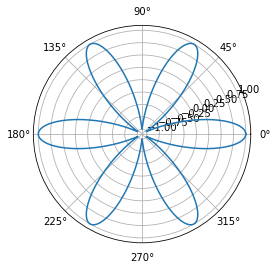

In [54]:
import numpy as np
import matplotlib.pyplot as plt
a = 1
k = 6
t = np.linspace(0, (2* np.pi),1000) 
r = a*np.cos(k*t)
plt.polar(t,r)
plt.save('polar.png')